## Introduction

Diabetes is one of the most prevalent chronic diseases worldwide and early identification of high-risk individuals plays a crucial role in prevention and timely medical intervention. With the increasing availability of healthcare data, machine learning techniques can be leveraged to assist in identifying patterns and risk factors associated with diabetes.

In this project, a supervised machine learning approach is used to build a diabetes risk prediction system based on patient health attributes such as glucose level, BMI, blood pressure, age, and hereditary factors. The objective of this analysis is not to provide a medical diagnosis, but to develop a screening-level predictive model that can estimate the probability of diabetes and highlight key risk indicators.

The workflow includes data understanding, exploratory data analysis (EDA), feature analysis, training multiple classification models, performance evaluation using appropriate metrics, and selection of the best-performing model. The final model’s performance is assessed using confusion matrix and ROC-AUC to ensure balanced evaluation beyond simple accuracy.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Dataset Loaded

In [2]:
df = pd.read_csv(r'diabetes.csv')
print("Loaded data shape:", df.shape)
print("Columns:", list(df.columns))

Loaded data shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


## EDA (Exploratory Data Analysis)

In [3]:
print("First 5 rows:")
print(df.head())

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## Outcome Distribution

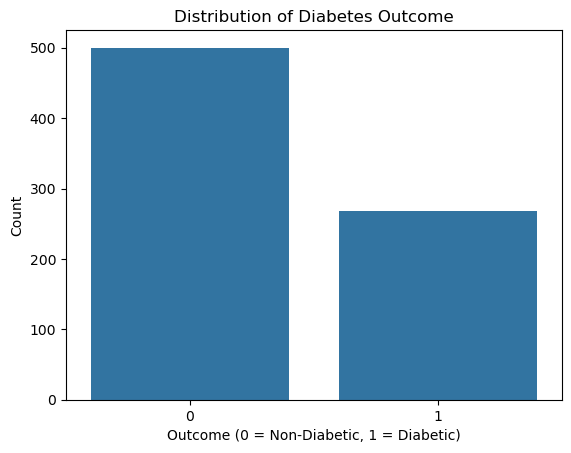

In [7]:
sns.countplot(x="Outcome", data=df)
plt.title("Distribution of Diabetes Outcome")
plt.xlabel("Outcome (0 = Non-Diabetic, 1 = Diabetic)")
plt.ylabel("Count")
plt.show()

In [8]:
possible_zero_na_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

In [9]:
# Only apply if such columns exist:

for c in possible_zero_na_cols:
    if c in df.columns:
        # Many datasets use 0 meaning missing for these features
        zero_count = (df[c] == 0).sum()
        if zero_count > 0:
            print(f"Column {c} has {zero_count} zeros - treating zeros as missing (NaN).")
            df.loc[df[c] == 0, c] = np.nan

Column Glucose has 5 zeros - treating zeros as missing (NaN).
Column BloodPressure has 35 zeros - treating zeros as missing (NaN).
Column SkinThickness has 227 zeros - treating zeros as missing (NaN).
Column Insulin has 374 zeros - treating zeros as missing (NaN).
Column BMI has 11 zeros - treating zeros as missing (NaN).


## Glucose Level vs Diabetes Outcome

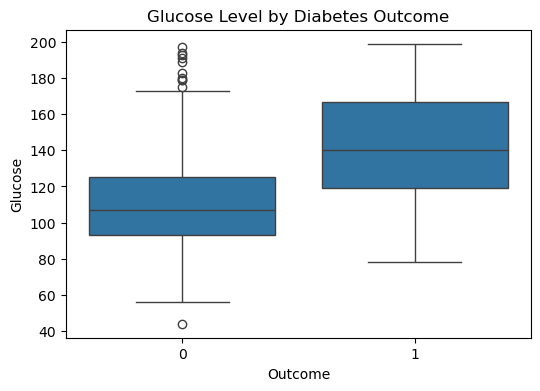

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Outcome", y="Glucose", data=df)
plt.title("Glucose Level by Diabetes Outcome")
plt.show()

## BMI vs Diabetes Outcome


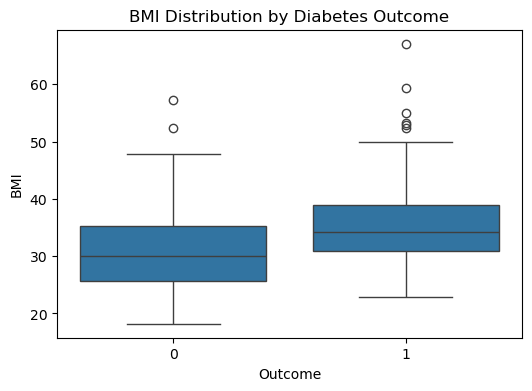

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Outcome", y="BMI", data=df)
plt.title("BMI Distribution by Diabetes Outcome")
plt.show()

## Age vs Diabetes Outcome


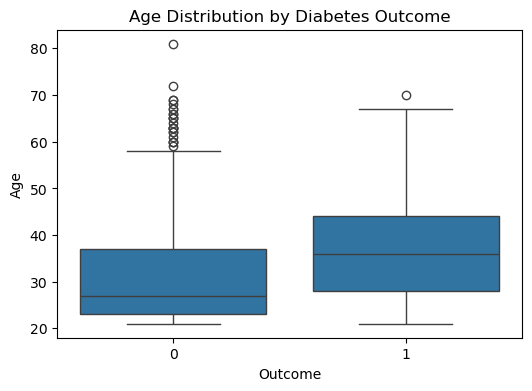

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Outcome", y="Age", data=df)
plt.title("Age Distribution by Diabetes Outcome")
plt.show()

## Prepare features and target

In [13]:
# Attempt to auto-detect target column: common names: 'Outcome','Diabetes','Target'

target_candidates = ['Outcome', 'Diabetes', 'target', 'Target', 'CLASS', 'Label']
target_col = None
for t in target_candidates:
    if t in df.columns:
        target_col = t
        break

In [14]:
# If still None, assume last column is target

if target_col is None:
    target_col = df.columns[-1]
    print(f"No common target name found. Using last column as target: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

In [15]:
X.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

## Feature Correlation Heatmap


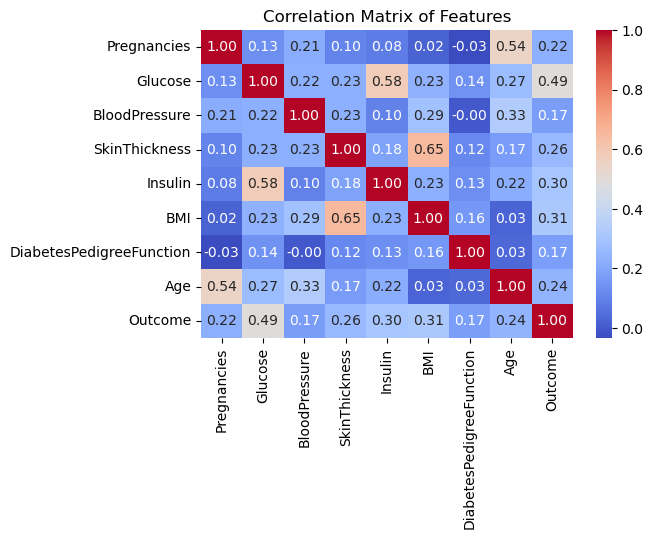

In [16]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Split dataset


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (614, 8), Test shape: (154, 8)


## Preprocessing pipeline

In [19]:
# numeric columns

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# if there are categorical columns, you could add handling; here we assume numeric features
print("Numeric columns used:", num_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols)
], remainder='drop')  # drop non-numeric columns by default

Numeric columns used: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Model candidates and pipelines

In [21]:
models = {
    'LogisticRegression': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'RandomForest': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'SVM': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

## Train and evaluate each model (basic)

In [22]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix,RocCurveDisplay)

In [23]:
results = {}
for name, pipe in models.items():
    print("-"*30)
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'pipeline': pipe,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    }

    print(f"{name} metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC_AUC={roc if roc is None else f'{roc:.4f}'}")

------------------------------

Training LogisticRegression...
LogisticRegression metrics: Accuracy=0.7078, Precision=0.6000, Recall=0.5000, F1=0.5455, ROC_AUC=0.8130
------------------------------

Training RandomForest...
RandomForest metrics: Accuracy=0.7727, Precision=0.7021, Recall=0.6111, F1=0.6535, ROC_AUC=0.8181
------------------------------

Training SVM...
SVM metrics: Accuracy=0.7403, Precision=0.6522, Recall=0.5556, F1=0.6000, ROC_AUC=0.7964


## Pick best model (by F1, then ROC)

In [24]:
best_name = None
best_score = -1
for name, r in results.items():
    score = r['f1']
    if score > best_score:
        best_score = score
        best_name = name

best = results[best_name]
print(f"\nSelected best model: {best_name} with F1={best_score:.4f}")


Selected best model: RandomForest with F1=0.6535


## Detailed evaluation & plots for best model

In [25]:
best_pipe = best['pipeline']
y_pred_best = best_pipe.predict(X_test)
if hasattr(best_pipe.named_steps['clf'], "predict_proba"):
    y_prob_best = best_pipe.predict_proba(X_test)[:, 1]
else:
    # fall back to decision function if available
    if hasattr(best_pipe.named_steps['clf'], "decision_function"):
        df_scores = best_pipe.decision_function(X_test)
        # scale to [0,1] conservatively
        y_prob_best = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)
    else:
        y_prob_best = None

## Example: predict on new sample(s)

In [26]:
# If you want to predict on a new sample, create a dict with same feature names:

new_sample = pd.DataFrame([{
    'Pregnancies': 2, 'Glucose': 120, 'BloodPressure': 70, 'SkinThickness': 20,
    'Insulin': 79, 'BMI': 25.1, 'DiabetesPedigreeFunction': 0.5, 'Age': 29
}])
pred = best_pipe.predict(new_sample)
prob = best_pipe.predict_proba(new_sample)[:,1] if hasattr(best_pipe.named_steps['clf'], 'predict_proba') else None
print("Pred:", pred, "Prob:", prob)

Pred: [0] Prob: [0.06]


## Confusion matrix


Confusion matrix (rows: true, cols: pred):
 [[86 14]
 [21 33]]


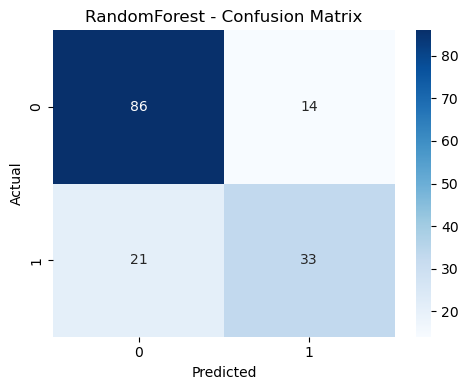

In [27]:
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion matrix (rows: true, cols: pred):\n", cm)

# Display confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_name} - Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## ROC curve if probabilities available

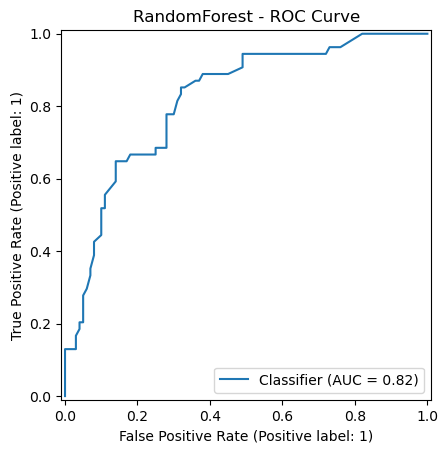

ROC AUC: 0.8180555555555555


In [28]:
if y_prob_best is not None:
    RocCurveDisplay.from_predictions(y_test, y_prob_best)
    plt.title(f"{best_name} - ROC Curve")
    plt.show()
    print("ROC AUC:", roc_auc_score(y_test, y_prob_best))

## Save the best model

In [35]:
import joblib

# extract ONLY the trained classifier from pipeline
best_model = best_pipe.named_steps['clf']

print(type(best_model))  # sanity check

joblib.dump(best_model, "best_diabetes_model.joblib")

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


['best_diabetes_model.joblib']

## Conclusion

In this project, a machine learning-based diabetes prediction system was successfully developed using structured patient health data. Exploratory data analysis revealed that features such as glucose level, BMI, and age have a strong influence on diabetes risk, which aligns with established medical understanding.

Multiple classification models were trained and evaluated, and the final model was selected based on objective performance metrics. The ROC curve analysis demonstrated the model’s ability to distinguish between diabetic and non-diabetic cases across different thresholds, making it suitable for screening-level risk assessment.

It is important to note that this model is limited by the size and scope of the dataset and should not be considered a substitute for professional medical diagnosis. The system is best viewed as a decision-support or preliminary risk evaluation tool.

Future improvements could include the use of larger and more diverse datasets, incorporation of additional clinical features, implementation of explainable AI techniques, and deployment as a real-time web application to enhance practical usability.
